In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
import requests
import bs4
from bs4 import BeautifulSoup
from IPython.display import Image
import datetime
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings('ignore')
from selenium.webdriver.chrome.options import Options
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
%matplotlib inline

### crawling

In [2]:
 #get temperature table from noaa website
my_url = 'https://www.ncdc.noaa.gov/cag/global/time-series/globe/land_ocean/all/12/1880-2021'

option = Options()

option.headless = False

driver = webdriver.Chrome(options=option)

driver.get(my_url)

driver.maximize_window()

action = webdriver.ActionChains(driver)

search_bar = WebDriverWait(driver,20).until(EC.presence_of_element_located((By.ID, 'valuesTable')))

html=driver.page_source
soup=BeautifulSoup(html,'html.parser')
div=soup.select_one("div#dataTable")
table=pd.read_html(str(div))
for i, tables in enumerate(table):
    tables.to_csv('noaaTemperature.csv')
    print(table[0])

In [3]:
url = 'https://global-warming.org'
tableUrl ='https://www.ncdc.noaa.gov/cag/'
HEADERS = {'user-agent': ('Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5)'
                           'AppleWebKit/537.36 (KHTML, like Gecko)'
                           'Chrome/45.0.2454.101 Safari/537.36'),
                           'referer': 'https://global-warming.org/'}

soup = requests.get(url)
temp =BeautifulSoup(soup.content, 'html.parser')
hrefs = temp.find_all("div", class_="content api-content")
for href in hrefs:
    print(href.b.contents[0].strip())
    response = requests.get(href.b.contents[0].strip(),headers=HEADERS)
    jsonurl = response.json()
    df = pd.json_normalize(jsonurl[list(response.json().keys())[-1]])
    df.to_csv(href.b.contents[0].strip().split("/")[-1].split("-")[0]+".csv",index=False)
    print(href.b.contents[0].strip().split("/")[-1].split("-")[0]+".csv")

https://global-warming.org/api/temperature-api
temperature.csv
https://global-warming.org/api/co2-api
co2.csv
https://global-warming.org/api/methane-api
methane.csv
https://global-warming.org/api/nitrous-oxide-api
nitrous.csv
https://global-warming.org/api/arctic-api
arctic.csv


In [4]:
temp = pd.read_csv('noaaTemperature.csv',usecols=['Year','Anomaly(1901-2000 Base Period)','Rank'])

In [5]:
temp.rename(columns={'Year':'year'},inplace = True)
temp['year'] = (temp['year']/100).astype(int)

In [6]:
co2_df = pd.read_csv('co2.csv',usecols=['year','month','day','cycle'])

In [7]:
df_energy = pd.read_csv("global-energy-substitution.csv",usecols = ['Coal (TWh; substituted energy)',
                                                            'Traditional bimass (TWh; substituted energy)',
                                                            'Oil (TWh; substituted energy)','Year'])

In [8]:
temp['Anomaly(1901-2000 Base Period)'] = temp['Anomaly(1901-2000 Base Period)'].str.replace(r'°C$', '')
temp['Anomaly(1901-2000 Base Period)'] = temp['Anomaly(1901-2000 Base Period)'].astype(float)

### Exploratory analysis:

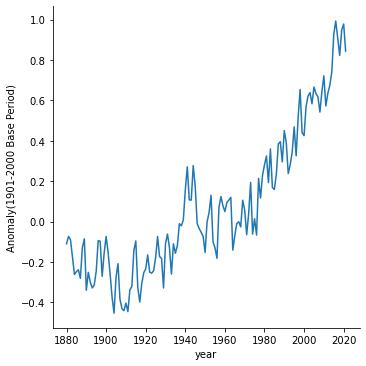

In [9]:
sns.relplot(x = 'year',y = 'Anomaly(1901-2000 Base Period)',data = temp,kind = 'line',ci = None)

In [10]:
temp['anamaly_smooth'] = temp['Anomaly(1901-2000 Base Period)'].rolling(100,1).apply(lambda x: np.nanmedian(x))

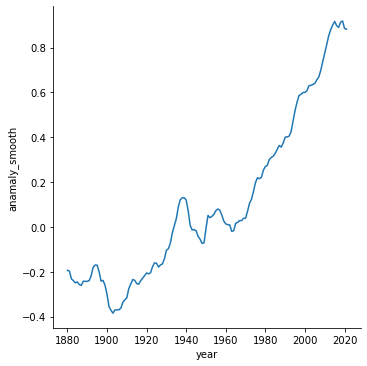

In [11]:
sns.relplot(x = 'year',y = 'anamaly_smooth',data = temp,kind = 'line',ci = None)

In [12]:
co2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3675 entries, 0 to 3674
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    3675 non-null   int64  
 1   month   3675 non-null   int64  
 2   day     3675 non-null   int64  
 3   cycle   3675 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 115.0 KB


#### since we need 50,000 enries - not enough data, we shall take data from other source

In [13]:
temp = pd.read_csv('temperature-anomaly.csv',usecols=['Year','Median temperature anomaly from 1961-1990 average'])

In [14]:
temp = temp.sort_values(by = 'Year')
temp = temp.groupby(['Year'],as_index = False).mean()

In [15]:
new_co2 = pd.read_csv('annual-co-emissions-by-region.csv')

In [16]:
new_co2_grouped = new_co2.groupby('Year',as_index=False).mean()

In [17]:
lst_dfs = []

In [18]:
co2_concentration = pd.read_csv('co2-concentration-long-term.csv')

In [19]:
co2_concentration = co2_concentration[co2_concentration['Year']>=1850]

In [20]:
df = temp.merge(co2_concentration,how = 'left',on = 'Year')

In [21]:
df = df.merge(new_co2_grouped,how = 'left',on = 'Year')

In [22]:
energy_data = pd.read_csv('energy_data.csv').drop('Unnamed: 0',axis = 1)

In [23]:
df_new = df.merge(energy_data,on = 'Year',how = 'left').drop(['Entity','Code'],axis = 1)

### clean and fill NA values

In [24]:
years = range(2021,999,-1)
months = range(12,0,-1)
df = pd.DataFrame(columns=["year","month"])
for year in years:
    for month in months:
        df =df.append({"year":year,"month":month},ignore_index=True)

In [25]:
def cleanData(data,name,pdToConcat):
    df = pd.read_csv(data)
    df=df.drop_duplicates(subset=['year'])
    if name =='methane':
        name1 = 'ch4'
    else:
        name1 = name
    try:
        df[name] = df[name].str.replace(r'°C$', '')
    except:
        print("not avilable")
    df['year'] = df['year'].str.replace(r'Year', 'May 12, ')
    df['year'] = df['year'].str.replace(r'-', ' 12, ')
    df_clean = pd.DataFrame()
    for index, row in df.iterrows():
        try:
            datee = datetime.datetime.strptime(row["year"], "%b %d, %y")
            df_clean = df_clean.append({"year":datee.year,"month":datee.month,name1:row[name]},ignore_index=True)
        except:
            try:
                datee = datetime.datetime.strptime(row["year"], "%B %d, %Y")
                df_clean = df_clean.append({"year":datee.year,"month":datee.month,name1:row[name]},ignore_index=True)
            except:
                try:
                    datee = datetime.datetime.strptime(row["year"], "%B %Y")
                    df_clean = df_clean.append({"year":datee.year,"month":datee.month,name1:row[name]},ignore_index=True)
                except:
                    datee = datetime.datetime.strptime(row["year"], "%B, %d, %Y")
                    df_clean = df_clean.append({"year":datee.year,"month":datee.month,name1:row[name]},ignore_index=True)
    df_clean['year'] = df_clean['year'].astype(int)
    df_clean['month'] = df_clean['month'].astype(int)
    df_clean = df_clean[['year','month',name1]]
    concatdata = pd.concat([pdToConcat,df_clean],ignore_index =True,sort=False)
    return concatdata

In [26]:
#delete °C fro teperature column
temp = pd.read_csv(r'noaaTemperature.csv')
co2 = pd.read_csv(r'co2.csv')
methane = pd.read_csv(r'methane.csv')
nitrous = pd.read_csv(r'nitrous.csv')
arctic = pd.read_csv(r'arctic.csv')
temp['Anomaly(1901-2000 Base Period)'] = temp['Anomaly(1901-2000 Base Period)'].str.replace(r'°C$', '')

#calc mean of month from co2 df
group_data = co2.groupby(['year','month']).sum()
co2['co2']=co2.groupby(['year','month']).cycle.transform('mean')
co2['co2_std'] = co2.groupby(['year','month']).cycle.transform(lambda x:stats.zscore(x))
co2.drop_duplicates(subset=['co2'],inplace=True,ignore_index=True)
co2.sort_values(by=['year', 'month'])
co2 = co2.drop(columns=['day','cycle','trend'])
data =pd.DataFrame()

#202104 - year -2021 , month - 04
temp['year'] = (temp['Year']/100).astype(int)
temp['month'] = (temp['Year']%100).astype(int)
#change col name
temp['temperature'] = (temp['Anomaly(1901-2000 Base Period)']).astype(float)
temp = temp.drop(columns=['Year','Rank','Anomaly(1901-2000 Base Period)'])


#methane data cleanind
methane = pd.read_csv(r'methane.csv')
methane['year'] = methane['date'].astype(int)
methane['month'] = np.where((np.modf(methane['date'])[0]>0.10)&(np.modf(methane['date'])[0]<0.13),(methane['date']*100%100).astype(int),(methane['date']*10%10).astype(int))
methane['month'] = methane['month'].replace(1,np.nan)
methane['ch4'] = methane['average']
methane = methane.drop(columns=['date','trend','averageUnc','trendUnc','average'])

#nitrous cleaning data
nitrous = pd.read_csv(r'nitrous.csv')
nitrous['year'] = nitrous['date'].astype(int)
nitrous['month'] = np.where((np.modf(nitrous['date'])[0]>0.10)&(np.modf(nitrous['date'])[0]<0.13),(nitrous['date']*100%100).astype(int),(nitrous['date']*10%10).astype(int))
nitrous['month'] = nitrous['month'].replace(1,np.nan)
nitrous['n2o'] = nitrous['average']
nitrous = nitrous.drop(columns=['date','trend','averageUnc','trendUnc','average'])

#merge dfs
data = pd.merge(temp,co2,on=['year','month'],how="left")
data = pd.merge(data,methane,on=['year','month'],how="left")
data = pd.merge(data,nitrous,on=['year','month'],how="left")
data = data[['year','month','temperature','co2','ch4','n2o']]
data

,year,month,temperature,co2,ch4,n2o
0,2021,12,0.83,417.129032,NaN,NaN
1,2021,11,0.91,415.691000,NaN,NaN
2,2021,10,0.89,413.859677,NaN,NaN
3,2021,9,0.89,412.011000,1900.5,334.4
4,2021,8,0.90,411.586774,1893.1,334.3
...,...,...,...,...,...,...
1699,1880,5,-0.08,NaN,NaN,NaN
1700,1880,4,-0.04,NaN,NaN,NaN
1701,1880,3,-0.08,NaN,NaN,NaN
1702,1880,2,-0.14,NaN,NaN,NaN


In [27]:
Temp_data = cleanData("globalTemperatura.csv",'temperature',temp)
Co2_data = cleanData("globalCo2.csv",'co2',co2)
Methane_data =cleanData("globalMethane.csv",'methane',methane)
Nitrous_data = cleanData("globalN2o.csv","n2o",nitrous)

not avilable
not avilable
not avilable


In [28]:
lst_dfs = [Temp_data,Co2_data,Methane_data,Nitrous_data]

In [29]:
mereged_df = reduce(lambda left,right:pd.merge(left,right,on = ['year','month'],how = 'outer'),
                   lst_dfs)

In [30]:
df_new.rename(columns = {'Year':'year'},inplace=True)

In [31]:
final_data = mereged_df.merge(df_new,how = 'left',on = 'year')

In [32]:
final_data = final_data[final_data['year']<2019]

In [33]:
final_data.to_csv('fina_data.csv')

In [65]:
final_data.head()

,Unnamed: 0,year,month,temperature,co2,co2_std,ch4,n2o,Median temperature anomaly from 1961-1990 average,"CO2 concentrations (NOAA, 2018)",...,Traditional bimass (TWh; substituted energy),Coal (TWh; substituted energy),smooth_co2,smooth_ch4,smooth_n2o,"smooth_CO2 concentrations (NOAA, 2018)",smooth_Annual CO2 emissions (zero filled),smooth_Oil (TWh; substituted energy),smooth_Traditional bimass (TWh; substituted energy),smooth_Coal (TWh; substituted energy)
56,36.0,2018,12.0,0.88,409.636774,-1.841299,1866.0,331.7,0.566,408.52,...,11111.0,44109.0,409.636774,1866.0,331.7,408.52,5.286113e+08,53181.0,11111.0,44109.0
57,37.0,2018,11.0,0.78,408.349667,-1.786880,1866.3,331.5,0.566,408.52,...,11111.0,44109.0,408.349667,1866.3,331.5,408.52,5.286113e+08,53181.0,11111.0,44109.0
58,37.0,2018,11.0,0.78,408.349667,-1.786880,1866.3,332.0,0.566,408.52,...,11111.0,44109.0,408.349667,1866.3,332.0,408.52,5.286113e+08,53181.0,11111.0,44109.0
59,NaN,2018,11.0,0.83,408.349667,-1.786880,1866.3,331.5,0.566,408.52,...,11111.0,44109.0,408.349667,1866.3,331.5,408.52,5.286113e+08,53181.0,11111.0,44109.0
60,NaN,2018,11.0,0.83,408.349667,-1.786880,1866.3,332.0,0.566,408.52,...,11111.0,44109.0,408.349667,1866.3,332.0,408.52,5.286113e+08,53181.0,11111.0,44109.0


In [36]:
def smooth_signal_and_fill_na(grouper,feature_name,df):
    new_feature_name = 'smooth_'+feature_name
    df[new_feature_name] = df[feature_name].rolling(60,1).apply(lambda x: np.median(x))
    df[new_feature_name] = df.groupby(grouper)[feature_name].transform(lambda x: x.fillna(x.mean()))

In [37]:
features_lst = ['co2', 'ch4',
       'n2o', 'CO2 concentrations (NOAA, 2018)', 'Annual CO2 emissions (zero filled)',
       'Oil (TWh; substituted energy)',
       'Traditional bimass (TWh; substituted energy)',
       'Coal (TWh; substituted energy)']

In [38]:
for feature in features_lst:
    smooth_signal_and_fill_na('year',feature,final_data)

In [39]:
relevant_columns = ['year', 'month','temperature',
                  'smooth_co2', 'smooth_ch4', 'smooth_n2o',
       'smooth_CO2 concentrations (NOAA, 2018)',
       'smooth_Annual CO2 emissions (zero filled)',
       'smooth_Oil (TWh; substituted energy)',
       'smooth_Traditional bimass (TWh; substituted energy)',
       'smooth_Coal (TWh; substituted energy)' ]

In [40]:
prediction_data = final_data[relevant_columns].dropna()

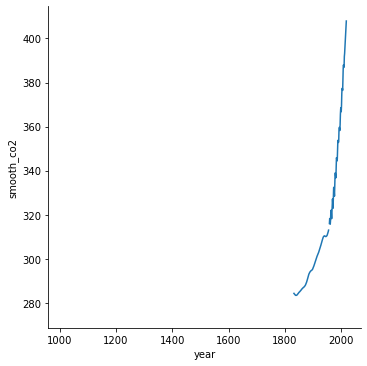

In [68]:
sns.relplot(x = 'year',y = 'smooth_co2',data  = final_data,kind = 'line',ci = None)

#### start predictios

In [42]:
def find_best_random_forest_num_estimators(X_train, y_train):
    parameters = {'n_estimators':[70,100,300,500,1000,2000] }
    rf = RandomForestRegressor()
    clf = GridSearchCV(rf, parameters,scoring=make_scorer(metrics.r2_score, greater_is_better=True))
    clf.fit(X_train, y_train)
    best_num_estimators = clf.best_params_['n_estimators']
    return best_num_estimators

In [43]:
def Random_Forest(X_train, y_train):
    best_num_estimators = find_best_random_forest_num_estimators(X_train, y_train)
    params = {'num_estimator':best_num_estimators}
    clf = RandomForestRegressor(n_estimators=params['num_estimator'], random_state=0)
    print("Best num estimator is:",best_num_estimators,"\n")
    return clf

In [44]:
X = prediction_data[['year', 'month',
                  'smooth_co2', 'smooth_ch4', 'smooth_n2o',
       'smooth_CO2 concentrations (NOAA, 2018)',
       'smooth_Annual CO2 emissions (zero filled)',
       'smooth_Oil (TWh; substituted energy)',
       'smooth_Traditional bimass (TWh; substituted energy)',
       'smooth_Coal (TWh; substituted energy)' ]]
y = prediction_data[['temperature']]

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Visualize features and correlations

<AxesSubplot:>

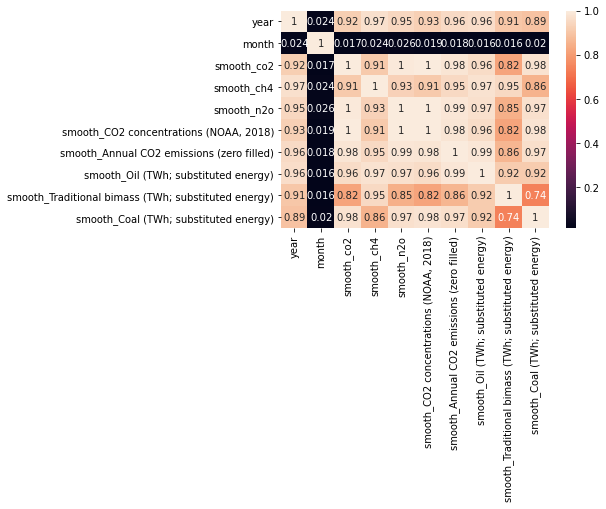

In [47]:
sns.heatmap(X.corr(),annot=True)### data is highly correlated

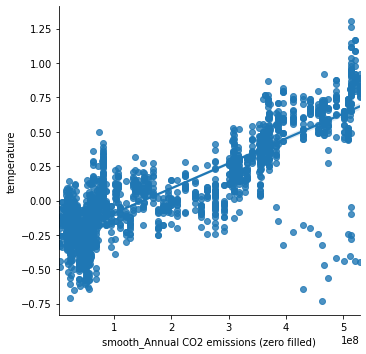

In [48]:
final_data['temperature'] = final_data['temperature'].astype(float)
sns.lmplot(x = 'smooth_Annual CO2 emissions (zero filled)',y ='temperature',data = final_data )
#since data is highly correlated, no need to vis. other features

### ML - Random Forest (was chosen since data is not linearly correlated)

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [50]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [51]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [52]:
predictions = rf.predict(X_test)

In [53]:
machine= []
Intercept = []
R2 = []
Absolute_err = []
Squared_err = []
Mean_sq = []

In [54]:
def add_results(clf,name,X,y):
#     R2.append(round(metrics.r2_score(y,clf.predict(X)), 5))
    Absolute_err.append(round(metrics.mean_absolute_error(y,clf.predict(X)), 5))
    Squared_err.append(round(metrics.mean_squared_error(y,clf.predict(X)), 5))
    Mean_sq.append(round(np.sqrt(metrics.mean_squared_error(y,clf.predict(X))), 5))
    machine.append(name)

def print_resulrs(clf,X,y):
    print("R2:",clf.score(X,y))
    print("R2:",metrics.r2_score(y,clf.predict(X)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y,clf.predict(X)))
    print('Mean Squared Error:', metrics.mean_squared_error(y,clf.predict(X)))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y,clf.predict(X))))

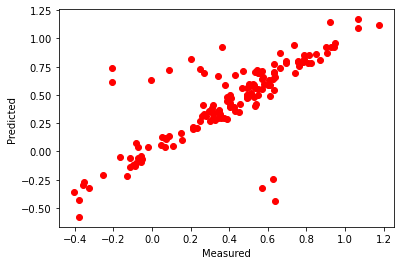

R2: 0.8741089565010879
R2: 0.8741089565010879
Mean Absolute Error: 0.0543311612994962
Mean Squared Error: 0.01579852730147929
Root Mean Squared Error: 0.12569219268307513


In [55]:
add_results(rf,"Random Fores",X_train, y_train)
plt.scatter(predictions, y_test,  color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.show()
print_resulrs(rf,X_train, y_train)

### Predict next year

In [56]:
y_shifted = y.shift(-12).dropna()

In [57]:
X_shifted = X.shift(-12).dropna()

In [58]:
data_to_predict=final_data.shift(-12)

data_to_predict= data_to_predict.dropna()
#train
X_train, X_test, y_train, y_test = train_test_split(data_to_predict[['year', 'month',
                  'smooth_co2', 'smooth_ch4', 'smooth_n2o',
       'smooth_CO2 concentrations (NOAA, 2018)',
       'smooth_Annual CO2 emissions (zero filled)',
       'smooth_Oil (TWh; substituted energy)',
       'smooth_Traditional bimass (TWh; substituted energy)',
       'smooth_Coal (TWh; substituted energy)' ]],
                                                    data_to_predict[['temperature']]*100, test_size=0.2, random_state=0)
regressor = Random_Forest(X_train, y_train)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

Best num estimator is: 70 



In [59]:
print("R2:",metrics.r2_score(y_test,regressor.predict(X_test)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,regressor.predict(X_test)))
print('Mean Squared Error:', metrics.mean_squared_error(y_test,regressor.predict(X_test)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,regressor.predict(X_test))))

R2: 0.872451131594993
Mean Absolute Error: 4.834821428571429
Mean Squared Error: 40.823609693877565
Root Mean Squared Error: 6.389335622259764


In [60]:
new_data_to_predict=final_data.copy()
predicted_years = range(2022, 999,-1)
predicted_months = range(12, 0,-1)

predicted_x= pd.DataFrame()
for y in predicted_years:
    for j in predicted_months:
        predicted_x = predicted_x.append({'date':y+j/100},ignore_index=True)
predicted_x = predicted_x.loc[9:].reset_index(drop=True)
new_data_to_predict['date'] = predicted_x['date']
new_data_to_predict.dropna(inplace = True)

In [61]:
y_pred = regressor.predict(new_data_to_predict[['year', 'month',
                  'smooth_co2', 'smooth_ch4', 'smooth_n2o',
       'smooth_CO2 concentrations (NOAA, 2018)',
       'smooth_Annual CO2 emissions (zero filled)',
       'smooth_Oil (TWh; substituted energy)',
       'smooth_Traditional bimass (TWh; substituted energy)',
       'smooth_Coal (TWh; substituted energy)' ]])

In [62]:
print('anomaly predicted:',y_pred.mean()/100)

anomaly predicted: 0.8137344537815125
